In [1]:
import pandas as pd
import pickle
import json
# import numpy

In [2]:
# "C:\Users\aidan\Box Sync\Main\VSCode\OpthoClaimsData\Demographic_Provider\DAC_NationalDownloadableFile.csv"
downloadable = pd.read_csv('DAC_NationalDownloadableFile.csv', encoding='latin-1', 
                           usecols=['NPI','Provider Last Name','Provider First Name', 'Provider Middle Name', 'gndr', 'Cred',
                            'Med_sch', 'Grd_yr', 'pri_spec', 'sec_spec_1','Telehlth', 'num_org_mem',
                            'City/Town', 'State', 'ZIP Code'])

KeyboardInterrupt: 

In [ ]:
downloadable['Provider Last Name'] = downloadable['Provider Last Name'].apply(lambda x: x.lower() if type(x) == str else x)
downloadable['Provider First Name'] = downloadable['Provider First Name'].apply(lambda x: x.lower() if type(x) == str else x)
downloadable = downloadable[downloadable.Cred.isin(['MD', 'DO'])]
downloadable = downloadable.drop_duplicates(subset=['NPI'])

In [ ]:
providers = pd.read_excel('Author_Results_Ortho_5.xlsx')
providers['lst_nm'] = providers.Name.apply(lambda x: x.split(',')[0].split(' ')[-1].lower())
providers['frst_nm'] = providers.Name.apply(lambda x: x.split(',')[0].split(' ')[0].lower())

In [ ]:
RCR = pd.read_excel('RCR.xlsx', usecols=['Name', 'state'])
providers = pd.merge(providers, RCR,  how='left', left_on='Name', right_on ='Name')

In [ ]:
from tqdm import tqdm
from pprint import pprint
count = 0
providers['NPI'] = ''
providers['gender'] = ''
providers['enrole'] = ''
providers['cred'] = ''

import requests

for index, row in tqdm(providers.iterrows()):
    first = row.frst_nm
    last = row.lst_nm
    state = row.state
    if type(state) != float:
        response = requests.get(f'https://npiregistry.cms.hhs.gov/api/?number=&enumeration_type=&taxonomy_description=&name_purpose=&first_name={first}&use_first_name_alias=&last_name={last}&organization_name=&address_purpose=&city=&state={state}&postal_code=&country_code=&limit=&skip=&pretty=&version=2.1')
    else:
        response = requests.get(f'https://npiregistry.cms.hhs.gov/api/?number=&enumeration_type=&taxonomy_description=&name_purpose=&first_name={first}&use_first_name_alias=&last_name={last}&organization_name=&address_purpose=&city=&state=&postal_code=&country_code=&limit=&skip=&pretty=&version=2.1')
    response = response.json()
    matched = False
    final_numbers = []
    for match in range(response['result_count']):
        for tax in response['results'][match]['taxonomies']:
            if 'orthopaedic'  in tax['desc'].lower():
                final_numbers.append(match)
                matched = True
    if matched:
        if len(final_numbers) > 1:
            count += 1
        final_number = final_numbers[0]
        NPI = response['results'][final_number]['number']
        gender = response['results'][final_number]['basic']['gender']
        try:
            cred = response['results'][final_number]['basic']['credential']
        except:
            cred = 'NA'
        enrole = int(response['results'][final_number]['basic']['enumeration_date'].split('-')[0])
    else:
        NPI = 'NA'
        gender = 'NA'
        cred = 'NA'
        enrole = 'NA'
    providers.loc[index, 'NPI'] = NPI
    providers.loc[index, 'gender'] = gender
    providers.loc[index, 'enrole'] = enrole
    providers.loc[index, 'cred'] = cred


778it [02:04,  6.23it/s]


In [122]:
providersmerge = providers[providers.NPI != 'NA']

In [123]:
providersmerge['NPI']=providersmerge['NPI'].astype(int)
downloadable['NPI']=downloadable['NPI'].astype(int)

providers_downloadable = pd.merge(providersmerge, downloadable,  how='left', left_on='NPI', right_on ='NPI')

C:\Users\aidan\AppData\Local\Temp\ipykernel_21304\3284309466.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  providersmerge['NPI']=providersmerge['NPI'].astype(int)


In [128]:
providers

,Name,total-pubs,pubs-per-year,cites-per-year-max,cites-per-year-mean,cites-per-year-sem,cites-per-year-med,rcr-max,rcr-mean,rcr-sem,rcr-med,wrcr,lst_nm,frst_nm,state,NPI,gender,enrole,cred
0,"Damon DelBello, MD",3.0,0.50,1.33,0.58,0.40,0.40,0.99,0.63,0.36,0.63,1.26,delbello,damon,NY,1386731776,M,2006,MD
1,"Kristina S. Walick, MD",5.0,0.45,2.67,1.83,0.42,2.00,1.68,1.16,0.24,1.16,5.80,walick,kristina,IL,1518942325,F,2005,M.D.
2,"Jennifer Ty, MD",11.0,0.69,3.79,1.04,0.32,1.00,1.59,0.79,0.21,0.59,5.56,ty,jennifer,DE,1174605414,F,2006,MD
3,"Patrick M. Riley, Jr., MD",9.0,0.31,3.00,1.59,0.29,1.67,5.21,1.77,0.47,1.20,15.90,riley,patrick,OH,1356582167,M,2009,M.D.
4,"Sheryl Handler-Matasar, MD",1.0,1.00,1.25,1.25,0.00,1.25,0.90,0.90,0.00,0.90,0.90,handler-matasar,sheryl,OH,1376510354,F,2006,MD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
773,"James Gregory, MD",39.0,2.05,10.75,2.46,0.47,1.00,5.52,1.56,0.27,1.25,48.51,gregory,james,OK,1912132390,M,2009,MD
774,"David D. Spence, MD",35.0,2.92,7.57,1.76,0.26,1.50,4.71,1.32,0.19,1.08,38.31,spence,david,TN,1730395542,M,2007,MD
775,"Peter D. Fabricant, MD, MPH",214.0,12.59,22.29,2.86,0.22,2.00,12.05,1.93,0.14,1.37,352.06,fabricant,peter,NY,1972762433,M,2008,M.D.
776,"Sekinat Kassim McCormick, MD",2.0,0.67,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,mccormick,sekinat,TX,1700016524,F,2009,MD


In [130]:
providers.to_csv('regression_providers.csv')

In [2]:
providers = pd.read_csv('regression_providers.csv', index_col=0)
providers

,Name,total-pubs,pubs-per-year,cites-per-year-max,cites-per-year-mean,cites-per-year-sem,cites-per-year-med,rcr-max,rcr-mean,rcr-sem,rcr-med,wrcr,lst_nm,frst_nm,state,NPI,gender,enrole,cred
0,"Damon DelBello, MD",3.0,0.50,1.33,0.58,0.40,0.40,0.99,0.63,0.36,0.63,1.26,delbello,damon,NY,1.386732e+09,M,2006.0,MD
1,"Kristina S. Walick, MD",5.0,0.45,2.67,1.83,0.42,2.00,1.68,1.16,0.24,1.16,5.80,walick,kristina,IL,1.518942e+09,F,2005.0,M.D.
2,"Jennifer Ty, MD",11.0,0.69,3.79,1.04,0.32,1.00,1.59,0.79,0.21,0.59,5.56,ty,jennifer,DE,1.174605e+09,F,2006.0,MD
3,"Patrick M. Riley, Jr., MD",9.0,0.31,3.00,1.59,0.29,1.67,5.21,1.77,0.47,1.20,15.90,riley,patrick,OH,1.356582e+09,M,2009.0,M.D.
4,"Sheryl Handler-Matasar, MD",1.0,1.00,1.25,1.25,0.00,1.25,0.90,0.90,0.00,0.90,0.90,handler-matasar,sheryl,OH,1.376510e+09,F,2006.0,MD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
773,"James Gregory, MD",39.0,2.05,10.75,2.46,0.47,1.00,5.52,1.56,0.27,1.25,48.51,gregory,james,OK,1.912132e+09,M,2009.0,MD
774,"David D. Spence, MD",35.0,2.92,7.57,1.76,0.26,1.50,4.71,1.32,0.19,1.08,38.31,spence,david,TN,1.730396e+09,M,2007.0,MD
775,"Peter D. Fabricant, MD, MPH",214.0,12.59,22.29,2.86,0.22,2.00,12.05,1.93,0.14,1.37,352.06,fabricant,peter,NY,1.972762e+09,M,2008.0,M.D.
776,"Sekinat Kassim McCormick, MD",2.0,0.67,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,mccormick,sekinat,TX,1.700017e+09,F,2009.0,MD


In [3]:
def cred_func(x):
    degrees = x.split(',')[1:]
    degrees = [x.strip().lower() for x in degrees]
    if 'md' in degrees:
        return 'MD'
    elif 'do' in degrees:
        return 'DO'
    else:
        return 'Unknown'

def phd_func(x):
    name = x.Name
    cred = x.cred
    degrees = name.split(',')[1:]
    degrees = [x.strip().lower() for x in degrees]
    
    if type(cred) == str:
        cred = cred.split(',')
        cred = [x.replace('.', '').strip().lower() for x in cred]
    else:
        cred = []
    # print(x, degrees)
    if 'phd' in degrees or 'phd' in cred:
        print(name, cred)
        return 1
    else:
        return 0

providers['PhD'] = providers.apply(lambda x: phd_func(x), axis = 1)
providers.cred = providers.Name.apply(lambda x: cred_func(x))


Nicholas Waanders, MD ['md', 'phd']
Peter J. Apel, MD ['md', 'phd']
Karen Myung, MD, PhD, MBA ['md']
J Todd Lawrence, MD, PhD []
Brian D. Snyder, MD ['md', 'phd']
Patrick William Whitlock, MD, PhD ['mdphd']
Melissa Ann Martinek, DO, PHD ['do']
John Cahoy, MD, PhD ['md/phd']
Julie Balch Samora, MD, PHD, MPH, FAAOS, FAOA ['md']
Jonathan G. Schoenecker, MD, PhD ['md', 'phd']
Yi-Meng Yen, MD ['md', 'phd']


In [4]:
region = pd.read_csv('main_data.csv', usecols=['STUSPS', 'region'])
state_to_region = {}
for index, row in region.iterrows():
    state_to_region[row.STUSPS] = row.region

In [5]:
def state_func(x):
    if type(x) == float:
        return 'Unknown'
    states = x.split(', ')
    regions = set([])
    for state in states:
        if state in state_to_region:
            regions.add(state_to_region[state])
    # print(x)
    # print(states)
    # print(regions)
    if len(regions) == 0:
        return 'Unknown'
    if len(regions)> 1:
        return list(regions)[0]
    else:
        return list(regions)[0]
providers['region'] = providers.state.apply(lambda x: state_func(x))
providers

,Name,total-pubs,pubs-per-year,cites-per-year-max,cites-per-year-mean,cites-per-year-sem,cites-per-year-med,rcr-max,rcr-mean,rcr-sem,...,wrcr,lst_nm,frst_nm,state,NPI,gender,enrole,cred,PhD,region
0,"Damon DelBello, MD",3.0,0.50,1.33,0.58,0.40,0.40,0.99,0.63,0.36,...,1.26,delbello,damon,NY,1.386732e+09,M,2006.0,MD,0,Northeast
1,"Kristina S. Walick, MD",5.0,0.45,2.67,1.83,0.42,2.00,1.68,1.16,0.24,...,5.80,walick,kristina,IL,1.518942e+09,F,2005.0,MD,0,Midwest
2,"Jennifer Ty, MD",11.0,0.69,3.79,1.04,0.32,1.00,1.59,0.79,0.21,...,5.56,ty,jennifer,DE,1.174605e+09,F,2006.0,MD,0,Northeast
3,"Patrick M. Riley, Jr., MD",9.0,0.31,3.00,1.59,0.29,1.67,5.21,1.77,0.47,...,15.90,riley,patrick,OH,1.356582e+09,M,2009.0,MD,0,Midwest
4,"Sheryl Handler-Matasar, MD",1.0,1.00,1.25,1.25,0.00,1.25,0.90,0.90,0.00,...,0.90,handler-matasar,sheryl,OH,1.376510e+09,F,2006.0,MD,0,Midwest
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
773,"James Gregory, MD",39.0,2.05,10.75,2.46,0.47,1.00,5.52,1.56,0.27,...,48.51,gregory,james,OK,1.912132e+09,M,2009.0,MD,0,Southwest
774,"David D. Spence, MD",35.0,2.92,7.57,1.76,0.26,1.50,4.71,1.32,0.19,...,38.31,spence,david,TN,1.730396e+09,M,2007.0,MD,0,Southeast
775,"Peter D. Fabricant, MD, MPH",214.0,12.59,22.29,2.86,0.22,2.00,12.05,1.93,0.14,...,352.06,fabricant,peter,NY,1.972762e+09,M,2008.0,MD,0,Northeast
776,"Sekinat Kassim McCormick, MD",2.0,0.67,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,mccormick,sekinat,TX,1.700017e+09,F,2009.0,MD,0,Southwest


In [6]:
providers['years'] = providers['enrole'].apply(lambda x: (2023-x) if type(x) == float else type(x)) 

In [7]:
providers.columns
regression_columns = ['gender', 'years', 'cred','region', 'PhD']
providers_reg = providers[providers.cred != 'Unknown']
providers_reg

,Name,total-pubs,pubs-per-year,cites-per-year-max,cites-per-year-mean,cites-per-year-sem,cites-per-year-med,rcr-max,rcr-mean,rcr-sem,...,lst_nm,frst_nm,state,NPI,gender,enrole,cred,PhD,region,years
0,"Damon DelBello, MD",3.0,0.50,1.33,0.58,0.40,0.40,0.99,0.63,0.36,...,delbello,damon,NY,1.386732e+09,M,2006.0,MD,0,Northeast,17.0
1,"Kristina S. Walick, MD",5.0,0.45,2.67,1.83,0.42,2.00,1.68,1.16,0.24,...,walick,kristina,IL,1.518942e+09,F,2005.0,MD,0,Midwest,18.0
2,"Jennifer Ty, MD",11.0,0.69,3.79,1.04,0.32,1.00,1.59,0.79,0.21,...,ty,jennifer,DE,1.174605e+09,F,2006.0,MD,0,Northeast,17.0
3,"Patrick M. Riley, Jr., MD",9.0,0.31,3.00,1.59,0.29,1.67,5.21,1.77,0.47,...,riley,patrick,OH,1.356582e+09,M,2009.0,MD,0,Midwest,14.0
4,"Sheryl Handler-Matasar, MD",1.0,1.00,1.25,1.25,0.00,1.25,0.90,0.90,0.00,...,handler-matasar,sheryl,OH,1.376510e+09,F,2006.0,MD,0,Midwest,17.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
773,"James Gregory, MD",39.0,2.05,10.75,2.46,0.47,1.00,5.52,1.56,0.27,...,gregory,james,OK,1.912132e+09,M,2009.0,MD,0,Southwest,14.0
774,"David D. Spence, MD",35.0,2.92,7.57,1.76,0.26,1.50,4.71,1.32,0.19,...,spence,david,TN,1.730396e+09,M,2007.0,MD,0,Southeast,16.0
775,"Peter D. Fabricant, MD, MPH",214.0,12.59,22.29,2.86,0.22,2.00,12.05,1.93,0.14,...,fabricant,peter,NY,1.972762e+09,M,2008.0,MD,0,Northeast,15.0
776,"Sekinat Kassim McCormick, MD",2.0,0.67,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,mccormick,sekinat,TX,1.700017e+09,F,2009.0,MD,0,Southwest,14.0


In [8]:
providers_reg.rename(columns={'rcr-mean': 'rcr_mean'}, inplace=True)

C:\Users\aidan\AppData\Local\Temp\ipykernel_18928\1731366110.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  providers_reg.rename(columns={'rcr-mean': 'rcr_mean'}, inplace=True)


In [9]:
providers_reg.columns

Index(['Name', 'total-pubs', 'pubs-per-year', 'cites-per-year-max',
       'cites-per-year-mean', 'cites-per-year-sem', 'cites-per-year-med',
       'rcr-max', 'rcr_mean', 'rcr-sem', 'rcr-med', 'wrcr', 'lst_nm',
       'frst_nm', 'state', 'NPI', 'gender', 'enrole', 'cred', 'PhD', 'region',
       'years'],
      dtype='object')

In [10]:
import statsmodels.formula.api as smf
import pandas as pd
import numpy as np

df = providers_reg[regression_columns+['wrcr', 'rcr_mean']]

# NB. unlike sm.OLS, there is "intercept" term is included here
regression = smf.ols(formula="wrcr ~ years + PhD + C(gender, Treatment(reference='F')) + C(cred, Treatment(reference='DO')) + C(region, Treatment(reference='Southwest'))", data=df).fit()

#This is to format, convert to ORs and output it to a CSV
params = regression.params
conf = regression.conf_int()
conf['Odds Ratio'] = params
conf.columns = ['5%', '95%', 'Odds Ratio']
conf["Formatted"] = 0
conf["P"] = regression.pvalues
for index, x in conf.iterrows():
    OR = x['Odds Ratio']
    five = x['5%']
    ninefive = x['95%']
    conf.loc[index, 'Formatted'] = f'{OR:.2f} ({five:.2f}-{ninefive:.2f})'

conf = conf.drop(columns=["5%", "95%", 'Odds Ratio'])
conf = conf[conf.index != 'Intercept']
conf.index
variable = [x.split('T.')[1].split(']')[0] if len(x) > 10 else x for x in conf.index]
reference = [x.split('reference=\'')[1].split("'")[0] if len(x)> 10 else x for x in conf.index]
category = [x.split(' ')[0].split('(')[-1].split(',')[0].capitalize() for x in conf.index]

new_index = []
for index in range(len(conf.index)):
    if variable[index] == reference[index]:
        new_index.append(category[index])
    else:
        new_index.append(f'Category: {category[index]}, Reference: {reference[index]}, Variable: {variable[index]}')

conf.index = new_index
conf.to_csv('Multivariate_wrcr.csv')
# conf

In [11]:
#Univariate
main_df = pd.DataFrame(columns = ['Formatted', 'P'])
test_cols = ['years', 'gender', 'cred', 'region', 'PhD']
ref_cols = {"gender":'F', "cred":'DO', "region":'Southwest'}
for x in test_cols:
    if x in ref_cols:
        formula = f"wrcr ~ C({x}, Treatment(reference='{ref_cols[x]}'))" 
    else:
        formula = f"wrcr ~ {x}"
        
    #This just formats the result and groups all the univariates into one csv
    model = smf.ols(formula, data=providers_reg).fit()
    # print(model.summary())
    params = model.params
    conf = model.conf_int()
    conf['Odds Ratio'] = params
    conf.columns = ['5%', '95%', 'Odds Ratio']
    conf["Formatted"] = 0
    conf['P'] = 1
    for index, x in conf.iterrows():
        OR = x['Odds Ratio']
        five = x['5%']
        ninefive = x['95%']
        conf.loc[index, 'Formatted'] = f'{OR:.2f} ({five:.2f}-{ninefive:.2f})'
        conf.loc[index, 'P'] = model.pvalues[index]
    conf = conf.drop(columns=["5%", "95%", 'Odds Ratio'])
    main_df = pd.concat([main_df, conf])
main_df = main_df[main_df.index != 'Intercept']
variable = [x.split('T.')[1].split(']')[0] if len(x) > 10 else x for x in main_df.index]
reference = [x.split('reference=\'')[1].split("'")[0] if len(x)> 10 else x for x in main_df.index]
category = [x.split(' ')[0].split('(')[-1].split(',')[0].capitalize() for x in main_df.index]

new_index = []
for index in range(len(main_df.index)):
    if variable[index] == reference[index]:
        new_index.append(category[index])
    else:
        new_index.append(f'Category: {category[index]}, Reference: {reference[index]}, Variable: {variable[index]}')
main_df.index = new_index
main_df
# model.pvalues
main_df.to_csv('Univariate_wrcr.csv')

In [10]:
providers_reg

,Name,total-pubs,pubs-per-year,cites-per-year-max,cites-per-year-mean,cites-per-year-sem,cites-per-year-med,rcr-max,rcr_mean,rcr-sem,...,lst_nm,frst_nm,state,NPI,gender,enrole,cred,PhD,region,years
0,"Damon DelBello, MD",3.0,0.50,1.33,0.58,0.40,0.40,0.99,0.63,0.36,...,delbello,damon,NY,1.386732e+09,M,2006.0,MD,0,Northeast,17.0
1,"Kristina S. Walick, MD",5.0,0.45,2.67,1.83,0.42,2.00,1.68,1.16,0.24,...,walick,kristina,IL,1.518942e+09,F,2005.0,MD,0,Midwest,18.0
2,"Jennifer Ty, MD",11.0,0.69,3.79,1.04,0.32,1.00,1.59,0.79,0.21,...,ty,jennifer,DE,1.174605e+09,F,2006.0,MD,0,Northeast,17.0
3,"Patrick M. Riley, Jr., MD",9.0,0.31,3.00,1.59,0.29,1.67,5.21,1.77,0.47,...,riley,patrick,OH,1.356582e+09,M,2009.0,MD,0,Midwest,14.0
4,"Sheryl Handler-Matasar, MD",1.0,1.00,1.25,1.25,0.00,1.25,0.90,0.90,0.00,...,handler-matasar,sheryl,OH,1.376510e+09,F,2006.0,MD,0,Midwest,17.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
773,"James Gregory, MD",39.0,2.05,10.75,2.46,0.47,1.00,5.52,1.56,0.27,...,gregory,james,OK,1.912132e+09,M,2009.0,MD,0,Southwest,14.0
774,"David D. Spence, MD",35.0,2.92,7.57,1.76,0.26,1.50,4.71,1.32,0.19,...,spence,david,TN,1.730396e+09,M,2007.0,MD,0,Southeast,16.0
775,"Peter D. Fabricant, MD, MPH",214.0,12.59,22.29,2.86,0.22,2.00,12.05,1.93,0.14,...,fabricant,peter,NY,1.972762e+09,M,2008.0,MD,0,Northeast,15.0
776,"Sekinat Kassim McCormick, MD",2.0,0.67,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,mccormick,sekinat,TX,1.700017e+09,F,2009.0,MD,0,Southwest,14.0


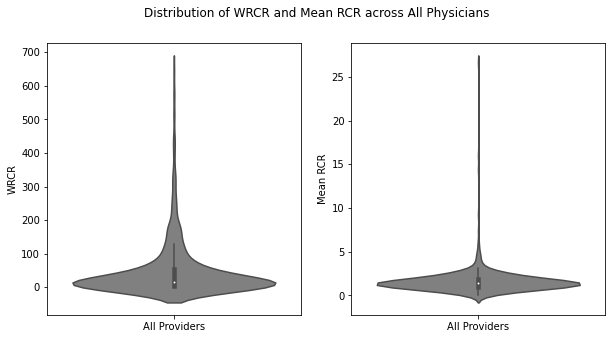

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


# Create subplots with shared x-axis
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# First violin plot on the left side
sns.violinplot(ax=ax1, data=providers_reg[['wrcr']], scale='width', color='grey')
ax1.set_ylabel('WRCR', color='black')

ax1.set_xticks([0])
ax1.set_xticklabels(['All Providers'])

# Create a second y-axis and plot on the right side
sns.violinplot(ax=ax2, data=providers_reg[['rcr_mean']], scale='width',  color='grey')
ax2.set_ylabel('Mean RCR', color='black')

ax2.set_xticks([0])
ax2.set_xticklabels(['All Providers'])


plt.suptitle('Distribution of WRCR and Mean RCR across All Physicians')


# plt.show()


plt.savefig("WRCR_Mean_RCR_Distribution.png", bbox_inches="tight", dpi=300, facecolor='white')


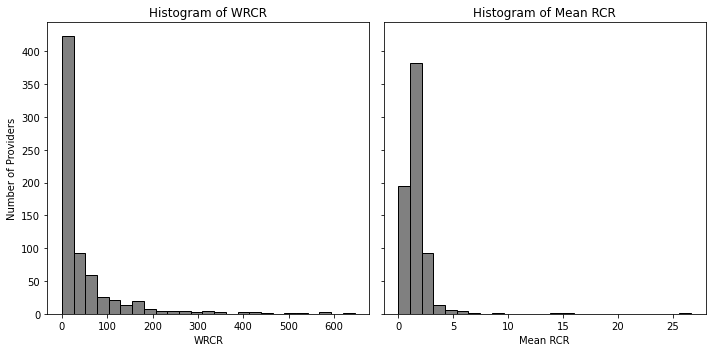

In [25]:
import pandas as pd
import matplotlib.pyplot as plt

# Creating subplots for histograms
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(10, 5))

# Plotting histogram for Column_A
ax1.hist(providers_reg['wrcr'], bins=25, alpha=1, color='grey', edgecolor='black')
ax1.set_xlabel('WRCR')
ax1.set_ylabel('Number of Providers')
ax1.set_title('Histogram of WRCR')

# Plotting histogram for Column_B
ax2.hist(providers_reg['rcr_mean'], bins=25, alpha=1, color='grey', edgecolor='black')
ax2.set_xlabel('Mean RCR')
ax2.set_title('Histogram of Mean RCR')

plt.tight_layout()
# plt.show()

plt.savefig("WRCR_Mean_RCR_Distribution_Histogram.png", bbox_inches="tight", dpi=300, facecolor='white')


C:\Users\aidan\AppData\Local\Temp\ipykernel_2896\573547496.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp.gender = temp.gender.apply(lambda x: 'Male' if x == 'M' else 'Female')


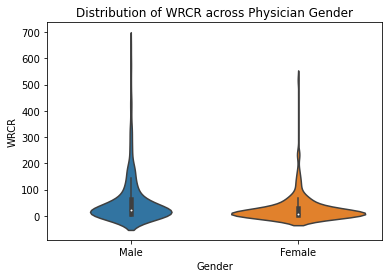

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Create a sample DataFrame
temp = providers_reg[['wrcr', 'gender', 'rcr_mean']]
temp.gender = temp.gender.apply(lambda x: 'Male' if x == 'M' else 'Female')
# Create a violin plot
sns.violinplot(x='gender', y='wrcr', data=temp)

plt.xlabel('Gender')
plt.ylabel('WRCR')

# Show the plot
plt.title('Distribution of WRCR across Physician Gender')
# plt.show()
plt.savefig("WRCR_Gender.png", bbox_inches="tight", dpi=300, facecolor='white')



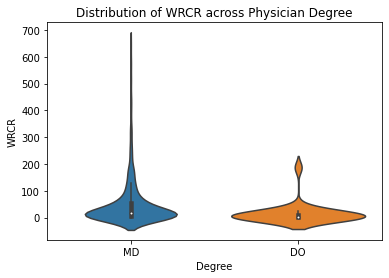

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Create a sample DataFrame


# Create a violin plot
sns.violinplot(x='cred', y='wrcr', data=providers_reg)

plt.xlabel('Degree')
plt.ylabel('WRCR')

# Show the plot
plt.title('Distribution of WRCR across Physician Degree')
# plt.show()

plt.savefig("WRCR_Degree.png", bbox_inches="tight", dpi=300, facecolor='white')


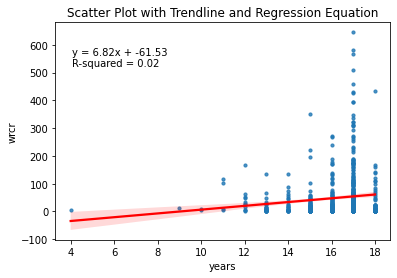

In [234]:
# import seaborn as sns
# import matplotlib.pyplot as plt
# import pandas as pd

# # Create a scatter plot with a trendline
# sns.regplot(x='years', y='wrcr', data=providers_reg)

# # Show the plot
# plt.title('Scatter Plot with Trendline')
# plt.show()


import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import linregress

temp = providers_reg[['years', 'wrcr']]
temp = temp.dropna()


# Create a scatter plot with a trendline
sns.regplot(x='years', y='wrcr', data=temp, scatter_kws={'s': 10}, line_kws={'color': 'red'})

# Calculate the linear regression parameters
slope, intercept, r_value, p_value, std_err = linregress(temp['years'], temp['wrcr'])

# Add equation and R-squared to the plot
equation = f'y = {slope:.2f}x + {intercept:.2f}'
r_squared = f'R-squared = {r_value**2:.2f}'

plt.annotate(equation, xy=(0.05, 0.85), xycoords='axes fraction', fontsize=10)
plt.annotate(r_squared, xy=(0.05, 0.80), xycoords='axes fraction', fontsize=10)

# Show the plot
plt.title('Scatter Plot with Trendline and Regression Equation')
plt.show()


In [29]:
from tableone import TableOne, load_dataset
columns = ['wrcr','rcr_mean', 'years', 'gender', 'cred', 'region', 'PhD']
categorical = [ 'gender', 'cred', 'region', 'PhD']
groupby = []
nonnormal = ['wrcr', 'years', 'rcr_mean']
labels={}
mytable = TableOne(providers_reg, columns=columns, categorical=categorical, groupby=groupby, nonnormal=nonnormal, rename=labels, pval=False)
print(mytable.tabulate(tablefmt = "csv"))
mytable.to_excel('Table1.xlsx')




                                     Missing    Overall
------------------------  ---------  ---------  ----------------
n                                               770
wrcr, median [Q1,Q3]                 72         15.6 [4.9,54.2]
rcr_mean, median [Q1,Q3]             72         1.4 [1.0,1.9]
years, median [Q1,Q3]                82         17.0 [16.0,17.0]
gender, n (%)             F          82         165 (24.0)
                          M                     523 (76.0)
cred, n (%)               DO         0          30 (3.9)
                          MD                    740 (96.1)
region, n (%)             Midwest    0          171 (22.2)
                          Northeast             170 (22.1)
                          Southeast             171 (22.2)
                          Southwest             96 (12.5)
                          Unknown               18 (2.3)
                          West                  144 (18.7)
PhD, n (%)                0          0          759

In [233]:
temp = providers_reg[['years', 'wrcr']]
temp.dropna()

,years,wrcr
0,17.0,1.26
1,18.0,5.80
2,17.0,5.56
3,14.0,15.90
4,17.0,0.90
...,...,...
773,14.0,48.51
774,16.0,38.31
775,15.0,352.06
776,14.0,0.00


In [226]:
print(slope, intercept, r_value, p_value, std_err)

nan nan nan nan nan


In [35]:
#Multivariate
import statsmodels.formula.api as smf

#Formula for top 4 CCs
formula ="wrcr ~ years + C(gender, Treatment(reference='M')) + C(cred, Treatment(reference='MD')) + C(region, Treatment(reference='Northeast'))"


log_reg = smf.OLS(formula, data=providers_reg).fit()

#This is to format, convert to ORs and output it to a CSV
print(log_reg.summary())
print(log_reg.pvalues)
params = log_reg.params
conf = log_reg.conf_int()
conf['Odds Ratio'] = params
conf.columns = ['5%', '95%', 'Odds Ratio']
conf = np.exp(conf)
conf["Formatted"] = 0
conf["P"] = log_reg.pvalues
for index, x in conf.iterrows():
    OR = x['Odds Ratio']
    five = x['5%']
    ninefive = x['95%']
    conf.loc[index, 'Formatted'] = f'{OR:.2f} ({five:.2f}-{ninefive:.2f})'

conf = conf.drop(columns=["5%", "95%", 'Odds Ratio'])
print(conf)
# conf.to_csv('Multivariate.csv')


AttributeError: module 'statsmodels.formula.api' has no attribute 'OLS'